This Exam Question 5

Consider the initial value problems (1) and (2). In this problem you must describe the classical Runge-Kutta method for solution of thse problems, implement a solver, and test it for the test problems describes in problem 1.

2. Implement an algorithm for classical Runge-Kutta with fixed time-step. 

(10, 1000)


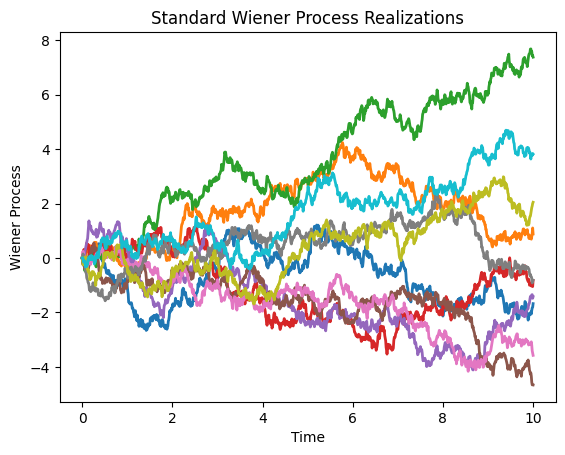

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
